In [1]:
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as pls
import seaborn as sea
import matplotlib.pyplot as plt 
import datetime as dt
import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
from sklearn.inspection import permutation_importance

import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore")

In [2]:
def format_pl():
    """FLOAT DISPLAY FORMATTING"""
    pl.Config.set_fmt_float("mixed")
    """STRING FORMATTING"""
    pl.Config.set_fmt_str_lengths(50)
    """TABLE FORMATTING"""
    pl.Config.set_tbl_rows(8)
    pl.Config.set_tbl_cols(15)
    pl.Config.set_tbl_width_chars(200)
    pl.Config.set_tbl_cell_alignment("RIGHT")
    pl.Config.set_tbl_hide_dtype_separator(True)
    pl.Config.set_tbl_hide_column_data_types(True)

format_pl()

In [3]:
SEED = 3126

# Reading Data

In [4]:
train = pl.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
test = pl.read_csv("/kaggle/input/playground-series-s5e1/test.csv")
sample_submission = pl.read_csv("/kaggle/input/playground-series-s5e1/sample_submission.csv")

train = train.drop(pl.col("id"))
test  = test.drop(pl.col("id"))

In [5]:
train

date,country,store,product,num_sold
"""2010-01-01""","""Canada""","""Discount Stickers""","""Holographic Goose""",null
"""2010-01-01""","""Canada""","""Discount Stickers""","""Kaggle""",973.0
"""2010-01-01""","""Canada""","""Discount Stickers""","""Kaggle Tiers""",906.0
"""2010-01-01""","""Canada""","""Discount Stickers""","""Kerneler""",423.0
…,…,…,…,…
"""2016-12-31""","""Singapore""","""Premium Sticker Mart""","""Kaggle""",2907.0
"""2016-12-31""","""Singapore""","""Premium Sticker Mart""","""Kaggle Tiers""",2299.0
"""2016-12-31""","""Singapore""","""Premium Sticker Mart""","""Kerneler""",1242.0
"""2016-12-31""","""Singapore""","""Premium Sticker Mart""","""Kerneler Dark Mode""",1622.0


In [6]:
test

date,country,store,product
"""2017-01-01""","""Canada""","""Discount Stickers""","""Holographic Goose"""
"""2017-01-01""","""Canada""","""Discount Stickers""","""Kaggle"""
"""2017-01-01""","""Canada""","""Discount Stickers""","""Kaggle Tiers"""
"""2017-01-01""","""Canada""","""Discount Stickers""","""Kerneler"""
…,…,…,…
"""2019-12-31""","""Singapore""","""Premium Sticker Mart""","""Kaggle"""
"""2019-12-31""","""Singapore""","""Premium Sticker Mart""","""Kaggle Tiers"""
"""2019-12-31""","""Singapore""","""Premium Sticker Mart""","""Kerneler"""
"""2019-12-31""","""Singapore""","""Premium Sticker Mart""","""Kerneler Dark Mode"""


# Data Processing

In [7]:
NA_features = train.select(
    pl.all().is_null().sum()
).unpivot(
    value_name="train_NA_count"
).filter(
    pl.col("train_NA_count") > 0
)

NA_features = NA_features.with_columns(
    (100*pl.col("train_NA_count")/train.shape[0]).alias("train_NA_pct")
)

print(NA_features)

shape: (1, 3)
┌──────────┬────────────────┬──────────────┐
│ variable ┆ train_NA_count ┆ train_NA_pct │
╞══════════╪════════════════╪══════════════╡
│ num_sold ┆           8871 ┆     3.854778 │
└──────────┴────────────────┴──────────────┘


In [8]:
unique_count = train.select(
    pl.all().n_unique()
).unpivot(
    value_name="train_unique_count"
)

unique_count = unique_count.sort(by="train_unique_count")
print(unique_count)

shape: (5, 2)
┌──────────┬────────────────────┐
│ variable ┆ train_unique_count │
╞══════════╪════════════════════╡
│    store ┆                  3 │
│  product ┆                  5 │
│  country ┆                  6 │
│     date ┆               2557 │
│ num_sold ┆               4038 │
└──────────┴────────────────────┘


In [9]:
train.filter(
    ~pl.col("num_sold").is_null()
).with_columns(
    np.log(pl.col("num_sold")).alias("log_num_sold")
).group_by(
    pl.col("country")
).agg(
    pl.col("log_num_sold").mean().alias("mean_log_num_sold")
).filter(
    pl.col("country").is_in({"Canada", "Kenya"})
)

country,mean_log_num_sold
"""Kenya""",2.831507
"""Canada""",6.559667


In [10]:
### Fill NA values in num_sold
train = train.with_columns(
    ### Fill Canada NA num_sold with e**6.56
    pl.when((pl.col("country") == "Canada") & pl.col("num_sold").is_null())
      .then(pl.col("num_sold").fill_null(np.exp(6.5596)))  
    ### Fill Kenya NA num_sold with e**2.83
      .when((pl.col("country") == "Kenya") & pl.col("num_sold").is_null())
      .then(pl.col("num_sold").fill_null(np.exp(2.8315))) 
    ## Retain other values
      .otherwise(pl.col("num_sold"))
      .alias("num_sold")    
)

In [11]:
### Count of categorical values per categorical variable
string_df = train.select(pls.string())

for feature in string_df.columns:
    count_df = string_df.group_by(
        pl.col(feature)
    ).agg(
        pl.count()
    ).sort(feature,  descending=True)
    print(count_df)

shape: (2_557, 2)
┌────────────┬───────┐
│       date ┆ count │
╞════════════╪═══════╡
│ 2016-12-31 ┆    90 │
│ 2016-12-30 ┆    90 │
│ 2016-12-29 ┆    90 │
│ 2016-12-28 ┆    90 │
│          … ┆     … │
│ 2010-01-04 ┆    90 │
│ 2010-01-03 ┆    90 │
│ 2010-01-02 ┆    90 │
│ 2010-01-01 ┆    90 │
└────────────┴───────┘
shape: (6, 2)
┌───────────┬───────┐
│   country ┆ count │
╞═══════════╪═══════╡
│ Singapore ┆ 38355 │
│    Norway ┆ 38355 │
│     Kenya ┆ 38355 │
│     Italy ┆ 38355 │
│   Finland ┆ 38355 │
│    Canada ┆ 38355 │
└───────────┴───────┘
shape: (3, 2)
┌──────────────────────┬───────┐
│                store ┆ count │
╞══════════════════════╪═══════╡
│    Stickers for Less ┆ 76710 │
│ Premium Sticker Mart ┆ 76710 │
│    Discount Stickers ┆ 76710 │
└──────────────────────┴───────┘
shape: (5, 2)
┌────────────────────┬───────┐
│            product ┆ count │
╞════════════════════╪═══════╡
│ Kerneler Dark Mode ┆ 46026 │
│           Kerneler ┆ 46026 │
│       Kaggle Tiers ┆ 46026 │
│   

In [12]:
train_new = train.with_columns(
    pl.col("date").str.to_date(format="%Y-%m-%d")
).with_columns(
    ### DATETIME EXTRACTION
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.day().alias("day"),
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.quarter().alias("quarter")
).with_columns(
    ### TRIG TRANSFORMS ON DATETIME FEATURES
    # Yearly pattern
    (np.cos(2*np.pi*pl.col("month")/12)).alias("cos_12months"),
    (np.sin(2*np.pi*pl.col("month")/12)).alias("sin_12months"),
    # Weekly pattern
    (np.cos(2*np.pi*pl.col("weekday")/7)).alias("cos_7days"),
    (np.sin(2*np.pi*pl.col("weekday")/7)).alias("sin_7days"),
    # Quarterly pattern if it exists??
    (np.cos(2*np.pi*pl.col("quarter")/4)).alias("cos_4quarters"),
    (np.sin(2*np.pi*pl.col("quarter")/4)).alias("sin_4quarters"),
).with_columns(
    ### APPROXIMATE YEARLY SEASONALITY OBTAINED FROM ANALYZING COUNTRIES
    pl.when( ((pl.col("month")==12) & (pl.col("day")==31)) | 
             ((pl.col("month")==1)  & (pl.col("day")==1))
           ).then(1)
      .otherwise(0)
      .alias("global_yearly_seasonality")
).with_columns(
    ### APPROXIMATE WEEKLY SEASONALITY OBTAINED FROM ANALYZING COUNTRIES VERSION 1
    pl.when( ((pl.col("month")==1) & (pl.col("day")%7==3)) | 
             ((pl.col("month")!=1) & (pl.col("day")%7==0))
           ).then(1)
      .otherwise(0)
      .alias("global_weekly_seasonality_v1")
).with_columns(
    ### APPROXIMATE WEEKLY SEASONALITY VERSION 2 (Intuitively obtained)
    pl.when(pl.col("weekday") == 7)
      .then(1)
      .otherwise(0)
      .alias("global_weekly_seasonality_v2")
).with_columns(
    ### GLUEING VALUES OF CATEGORICAL VARIABLES FOR COMPLEX RELATIONSHIPS
    pl.concat_str([pl.col("store"), pl.lit("_"), pl.col("product")]).alias("store_product"),
    pl.concat_str([pl.col("country"), pl.lit("_"), pl.col("store"), pl.lit("_"), pl.col("product")]).alias("country_store_product")
).drop(
    ## DROP FEATURES
    ["date", "weekday", "quarter", "day"]
).with_columns(
    ### CASTS MONTH TO CATEGORICAL TYPE
    pl.col("month").cast(pl.Utf8).cast(pl.Categorical)
)

In [13]:
test_new = test.with_columns(
    pl.col("date").str.to_date(format="%Y-%m-%d")
).with_columns(
    ### DATETIME EXTRACTION
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.day().alias("day"),
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.quarter().alias("quarter")
).with_columns(
    ### TRIG TRANSFORMS ON DATETIME FEATURES
    # Yearly pattern
    (np.cos(2*np.pi*pl.col("month")/12)).alias("cos_12months"),
    (np.sin(2*np.pi*pl.col("month")/12)).alias("sin_12months"),
    # Weekly pattern
    (np.cos(2*np.pi*pl.col("weekday")/7)).alias("cos_7days"),
    (np.sin(2*np.pi*pl.col("weekday")/7)).alias("sin_7days"),
    # Quarterly pattern if it exists??
    (np.cos(2*np.pi*pl.col("quarter")/4)).alias("cos_4quarters"),
    (np.sin(2*np.pi*pl.col("quarter")/4)).alias("sin_4quarters"),
).with_columns(
    ### APPROXIMATE YEARLY SEASONALITY OBTAINED FROM ANALYZING COUNTRIES
    pl.when( ((pl.col("month")==12) & (pl.col("day")==31)) | 
             ((pl.col("month")==1)  & (pl.col("day")==1))
           ).then(1)
      .otherwise(0)
      .alias("global_yearly_seasonality")
).with_columns(
    ### APPROXIMATE WEEKLY SEASONALITY OBTAINED FROM ANALYZING COUNTRIES VERSION 1
    pl.when( ((pl.col("month")==1) & (pl.col("day")%7==3)) | 
             ((pl.col("month")!=1) & (pl.col("day")%7==0))
           ).then(1)
      .otherwise(0)
      .alias("global_weekly_seasonality_v1")
).with_columns(
    ### APPROXIMATE WEEKLY SEASONALITY VERSION 2 (Intuitively obtained)
    pl.when(pl.col("weekday") == 7)
      .then(1)
      .otherwise(0)
      .alias("global_weekly_seasonality_v2")
).with_columns(
    ### GLUEING VALUES OF CATEGORICAL VARIABLES FOR COMPLEX RELATIONSHIPS
    pl.concat_str([pl.col("store"), pl.lit("_"), pl.col("product")]).alias("store_product"),
    pl.concat_str([pl.col("country"), pl.lit("_"), pl.col("store"), pl.lit("_"), pl.col("product")]).alias("country_store_product")
).drop(
    ## DROP FEATURES
    ["date", "weekday", "quarter", "day"]
).with_columns(
    ### CASTS MONTH TO CATEGORICAL TYPE
    pl.col("month").cast(pl.Utf8).cast(pl.Categorical)
)

In [14]:
X = train_new.drop(["num_sold"]).to_pandas()
y = train_new["num_sold"].to_pandas()

X = pd.get_dummies(X, columns=['month', 'country'], drop_first=False)

# Training and Validation process

In [15]:
def MAPE(y_true, y_pred):
    ab_props = np.abs(y_true-y_pred)/y_true
    return np.mean(ab_props)

In [16]:
def train_validate(model, X, y, model_type, n_splits=5):
    """
    model: Algorithm to be evaluated.
    X: full training data.
    y : full training target. 
    model_type : Type of classifier model in {"XGBoost", "LGBM", "CatBoost", None}
    n_splits: Number of splits for TimeSeriesSplit
    """
    history      = {}
    oof_preds    = []
    oof_truths   = []
    mape_scores  = []
    ts_split  = TimeSeriesSplit(n_splits=n_splits)

    for i,(train_fold,val_fold) in enumerate(ts_split.split(X)):
        cloned_model = clone(model)
        ### Splits data
        X_train, y_train = X.loc[train_fold, :], y[train_fold]
        X_val, y_val     = X.loc[val_fold,:], y[val_fold]
        ### Fits model and predicts
        if model_type=="XGBoost":
            cloned_model.fit(X_train, y_train,
                             eval_set=[(X_val, y_val)]
                            )
        elif model_type=="LGBM":
            cloned_model.fit(X_train, y_train,
                             eval_set=[(X_val, y_val)],
                             eval_metric="mape",
                             callbacks=[lightgbm.early_stopping(stopping_rounds=25, 
                                                                verbose=False, 
                                                                min_delta=0.001)]
                            )
        elif model_type=="CatBoost":
            cloned_model.fit(X_train, y_train,
                             eval_set=(X_val, y_val),
                             use_best_model=True
                            )
        else:
            cloned_model.fit(X_train, y_train)
        y_pred = cloned_model.predict(X_val)
        mape_score = MAPE(y_val, y_pred)
        
        ### Append oof results and score
        oof_preds.append(y_pred)
        oof_truths.append(y_val)
        mape_scores.append(mape_score)
        print(f"Fold {i+1} MAPE: {mape_score}")
        
    history["oof_preds"]   = oof_preds
    history["oof_truths"]  = oof_truths
    history["mape_scores"] = mape_scores
    return history

# Naive CatBoost Performance

In [17]:
# For catboostregressor
cat_features = ['store', 'product', 
                'store_product', 'country_store_product']

params = {
    "n_estimators":500,
    "max_depth":10,
    "learning_rate":.05,
    "od_pval":0.01,
    "od_wait":50,  
    "loss_function":"MAPE",
    "bagging_temperature":1.0,
}
params["cat_features"] = cat_features
params["random_state"] = SEED
params["thread_count"] = -1
params["verbose"] = 0

catboost = CatBoostRegressor(**params)
catboost_history = train_validate(catboost, X, y, model_type="CatBoost", n_splits=5)

Fold 1 MAPE: 0.36988068188986334
Fold 2 MAPE: 0.3879106431822641
Fold 3 MAPE: 0.3458643584511388
Fold 4 MAPE: 0.2938135887350166
Fold 5 MAPE: 0.1916204732533471


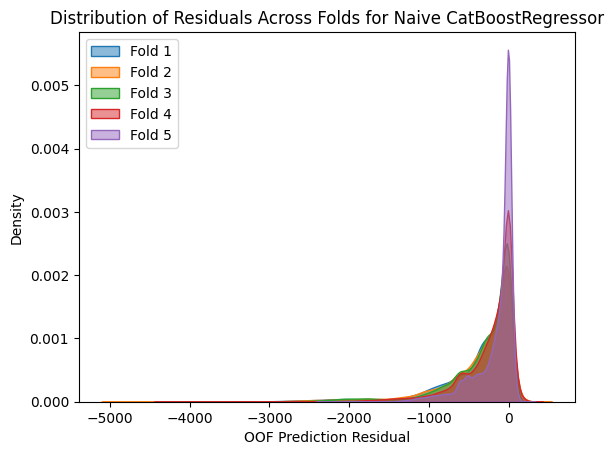

In [18]:
### Plots residual distribution across 5 folds
for k in range(5):
    sea.kdeplot(x=catboost_history["oof_preds"][k] - catboost_history["oof_truths"][k],
                label=f"Fold {k+1}",
                fill=True,
                alpha=.5
               )

plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.xlabel("OOF Prediction Residual")
plt.title("Distribution of Residuals Across Folds for Naive CatBoostRegressor")
plt.show()

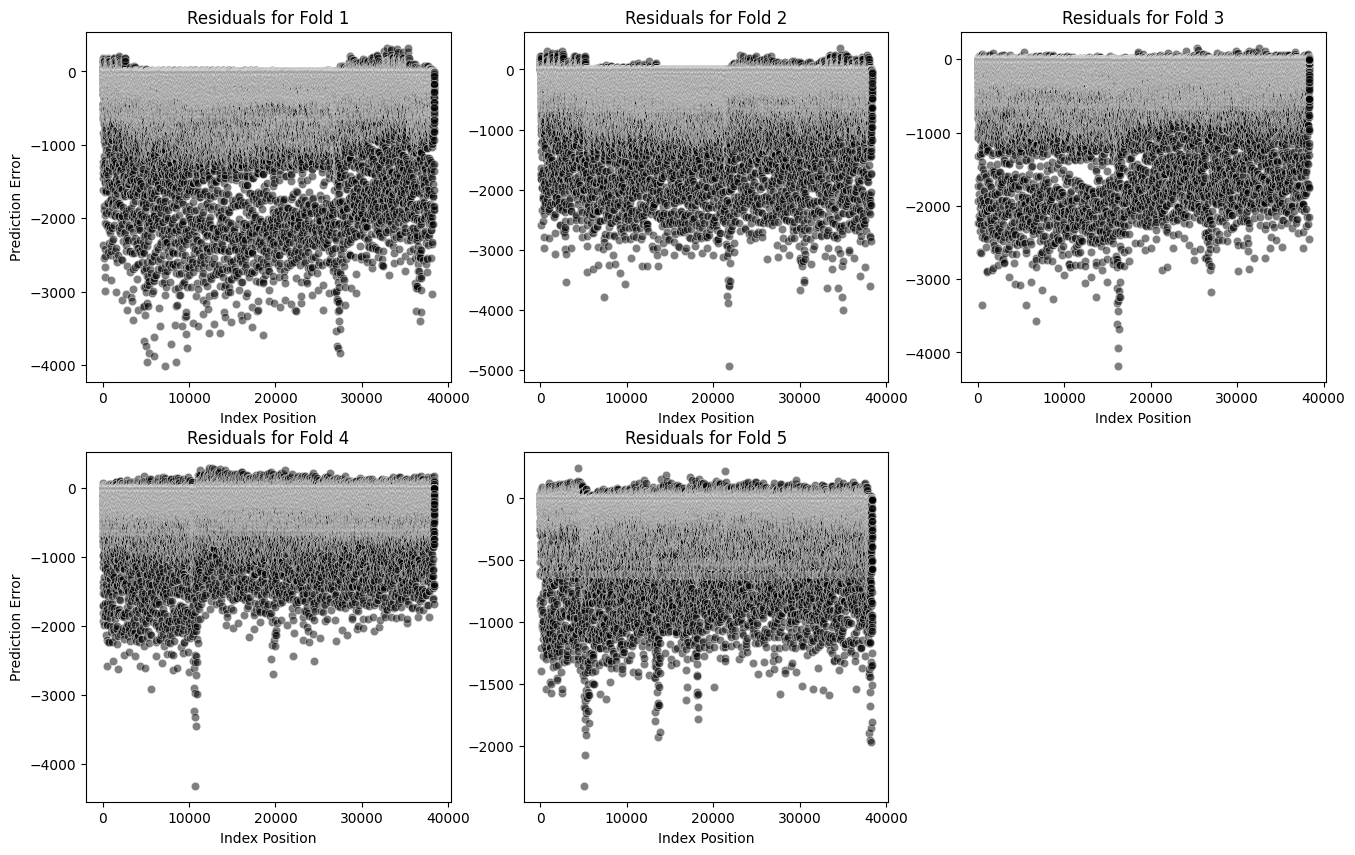

In [19]:
### Plots residual graphs individually
plt.figure(figsize=(16,10))
for k in range(5):
    residuals = catboost_history["oof_preds"][k] - catboost_history["oof_truths"][k]
    x_range = np.arange(len(residuals))
    plt.subplot(2, 3, k+1)
    sea.scatterplot(x=x_range,
                    y=residuals,
                    color="black",
                    alpha=.5)
    plt.title(f"Residuals for Fold {k+1}")
    plt.xlabel("Index Position")
    if k%3==0:
        plt.ylabel("Prediction Error")
    else:
        plt.ylabel("")
plt.show()

In [20]:
## Feature importance
ts_split  = TimeSeriesSplit(n_splits=2)
for train_indices, val_indices in ts_split.split(X):
    X_train, y_train = X.iloc[train_indices, :], y.iloc[train_indices]
    X_val, y_val = X.iloc[val_indices, :], y.iloc[val_indices]
    
model = CatBoostRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

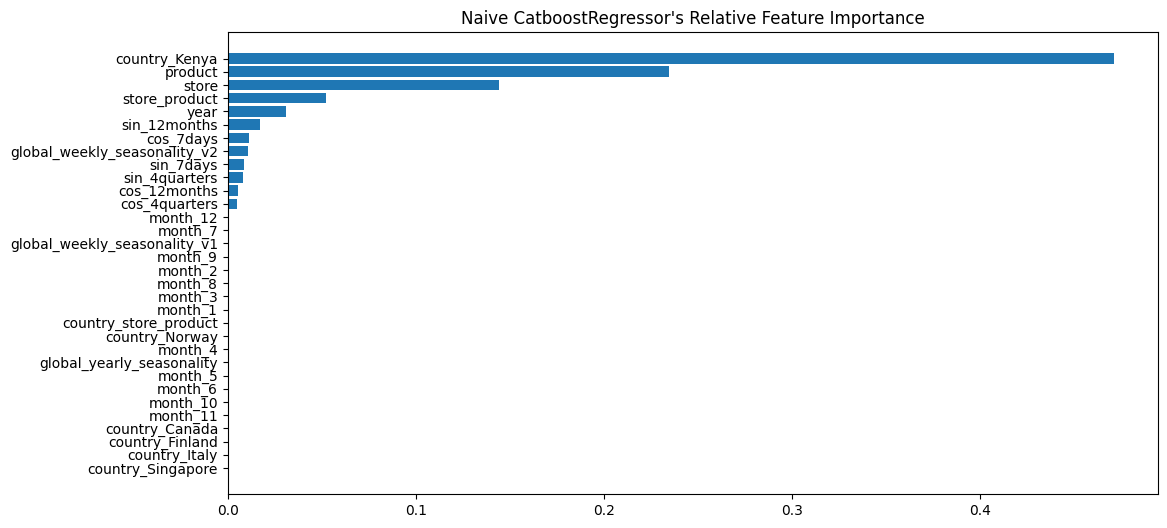

In [21]:
feature_importance = model.feature_importances_
feature_importance /= np.sum(feature_importance)
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title("Naive CatboostRegressor's Relative Feature Importance")
plt.show()

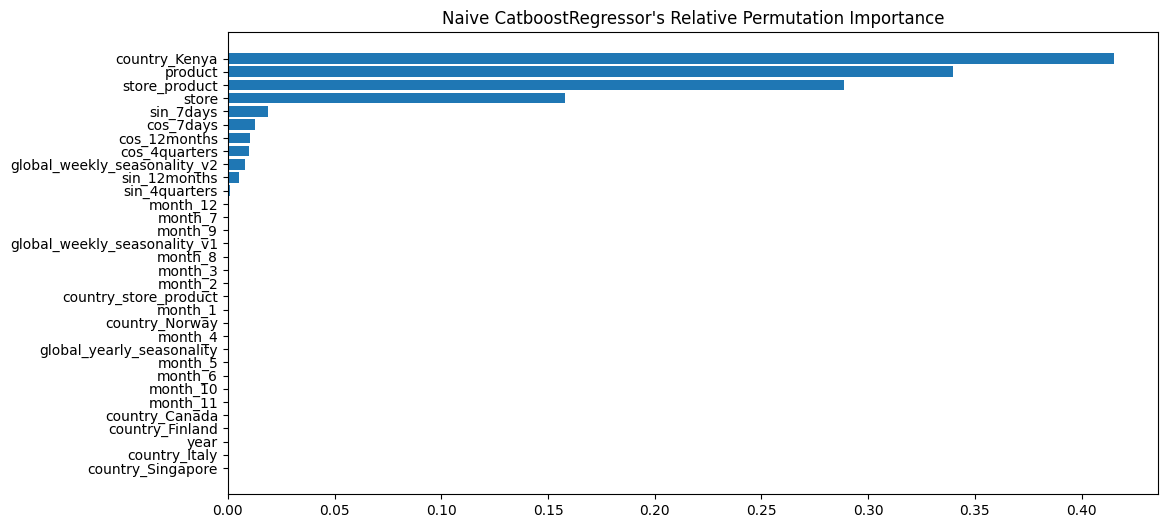

In [22]:
perm_importance = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=SEED)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title("Naive CatboostRegressor's Relative Permutation Importance")
plt.show()

# Tuning Catboosts

In [23]:
def validate(model, X, y, model_type, n_splits=5):
    mape_scores = []
    ts_split  = TimeSeriesSplit(n_splits=n_splits)

    for train_fold,val_fold in ts_split.split(X):
        cloned_model = clone(model)
        ### Splits data
        X_train, y_train = X.loc[train_fold, :], y[train_fold]
        X_val, y_val     = X.loc[val_fold,:], y[val_fold]
        ### Fits model and predicts
        if model_type=="XGBoost":
            cloned_model.fit(X_train, y_train,
                             eval_set=[(X_val, y_val)]
                            )
        elif model_type=="LGBM":
            cloned_model.fit(X_train, y_train,
                             eval_set=[(X_val, y_val)],
                             eval_metric="mape",
                             callbacks=[lightgbm.early_stopping(stopping_rounds=25, 
                                                                verbose=False, 
                                                                min_delta=0.001)]
                            )
        elif model_type=="CatBoost":
            cloned_model.fit(X_train, y_train,
                             eval_set=(X_val, y_val),
                             use_best_model=True
                            )
        else:
            cloned_model.fit(X_train, y_train)
        y_pred = cloned_model.predict(X_val)
        mape_score = MAPE(y_val, y_pred)
        
        ### Append oof results and score
        mape_scores.append(mape_score)
    return mape_scores

In [24]:
def catboost2_objective(trial):
    cat_features = ['store', 'product', 
                    'store_product', 'country_store_product']

    params = {
        "learning_rate":trial.suggest_float("learning_rate", .045, 1.0, log=True),
        "max_depth":trial.suggest_int("max_depth", 6, 12),
        "bagging_temperature":trial.suggest_float("bagging_temperature", 0.3, 0.7),
        "rsm":trial.suggest_float("rsm", 0.4, 0.7),
        "reg_lambda":trial.suggest_float("reg_lambda", .1, 5, log=True)
    }
    params["n_estimators"] = 925
    params["od_wait"] = 35
    params["od_pval"] = .05
    params["cat_features"] = cat_features
    params["random_state"] = SEED*2
    params["thread_count"] = -1
    params["verbose"] = 0
    params["loss_function"] = "MAPE"

    catboost = CatBoostRegressor(**params)
    scores = validate(catboost, X, y, model_type="CatBoost", n_splits=5)
    return np.mean(scores)

# study = optuna.create_study(
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(seed=SEED*2)
# )  
# study.optimize(catboost2_objective, n_trials=100)
# print("Best Score:", study.best_value)
# print("Best Hyperparameters:", study.best_params)

In [25]:
def catboost3_objective(trial):
    cat_features = ['store', 'product', 
                    'store_product', 'country_store_product']

    params = {
        "learning_rate":trial.suggest_float("learning_rate", 0.0555, 1.5, log=True),
        "max_depth":trial.suggest_int("max_depth", 6, 12),
        "bagging_temperature":trial.suggest_float("bagging_temperature", 0.3, 0.6),
        "rsm":trial.suggest_float("rsm", 0.3, 0.6),
        "reg_lambda":trial.suggest_float("reg_lambda", 1.75, 8.95, log=True)
    }
    params["n_estimators"] = 1000
    params["od_wait"] = 40
    params["od_pval"] = .05
    params["cat_features"] = cat_features
    params["random_state"] = SEED*3
    params["thread_count"] = -1
    params["verbose"] = 0
    params["loss_function"] = "MAPE"

    catboost = CatBoostRegressor(**params)
    scores = validate(catboost, X, y, model_type="CatBoost", n_splits=5)
    return np.mean(scores)

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED*3)
)  
study.optimize(catboost3_objective, n_trials=100)
print("Best Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-01-04 05:43:31,865] A new study created in memory with name: no-name-b51abd94-ca4f-4bb6-85a8-05cee472bc13
[I 2025-01-04 05:48:29,508] Trial 0 finished with value: 0.14695307175730796 and parameters: {'learning_rate': 0.07747917043936658, 'max_depth': 8, 'bagging_temperature': 0.49437243319248725, 'rsm': 0.5093983042410442, 'reg_lambda': 2.9020109435125}. Best is trial 0 with value: 0.14695307175730796.
[I 2025-01-04 05:55:45,336] Trial 1 finished with value: 0.14056208873529014 and parameters: {'learning_rate': 0.6252223677681306, 'max_depth': 10, 'bagging_temperature': 0.4664762066141991, 'rsm': 0.5857861935895816, 'reg_lambda': 2.1998503803099156}. Best is trial 1 with value: 0.14056208873529014.
[I 2025-01-04 06:04:16,754] Trial 2 finished with value: 0.15286459470181019 and parameters: {'learning_rate': 0.4547333563170784, 'max_depth': 11, 'bagging_temperature': 0.4771735721234398, 'rsm': 0.5594498537349704, 'reg_lambda': 8.082375694414424}. Best is trial 1 with value: 0.14

Best Score: 0.11148407929468943
Best Hyperparameters: {'learning_rate': 0.17978946154524098, 'max_depth': 9, 'bagging_temperature': 0.47610604753884067, 'rsm': 0.32439805779447306, 'reg_lambda': 4.563700308426288}


In [26]:
# Average MAPE Score: 0.1276
params1 = {
    'n_estimators': 983, 
    'max_depth': 9, 
    'learning_rate': 0.043854695927323585, 
    'od_pval': 0.05, 
    'od_wait': 34, 
    'bagging_temperature': 0.5798340764210204, 
    'rsm': 0.4116879241319616
}
params1["cat_features"] = cat_features
params1["random_state"] = SEED
params1["thread_count"] = -1
params1["verbose"] = 0
params1["loss_function"] = "MAPE"

In [27]:
## Mean MAPE score: 0.1157
params2 = {
    'learning_rate': 0.22518187244446547, 
    'max_depth': 9, 
    'bagging_temperature': 0.4638874901117373, 
    'rsm': 0.4343933628515776, 
    'reg_lambda': 1.5647658729577454
}
params2["n_estimators"] = 925
params2["od_wait"] = 35
params2["od_pval"] = .05
params2["cat_features"] = cat_features
params2["random_state"] = SEED*2
params2["thread_count"] = -1
params2["verbose"] = 0
params2["loss_function"] = "MAPE"